In [1]:
# !pip install hmmlearn
# !pip install quantstats
# !pip install dtale

In [2]:
import datetime
import numpy as np
import pylab as pl
import pandas as pd
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from hmmlearn.hmm import GaussianHMM

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import yfinance as yf

import quantstats as qs
qs.extend_pandas()

import seaborn as sns
sns.set_style('whitegrid')

import dtale

SHILLER_DATA_URL = 'http://www.econ.yale.edu/~shiller/data/ie_data.xls'

%matplotlib inline

In [3]:
###############################################################################
# Downloading the data
date1 = datetime.date(2016, 1, 1)  # start date
date2 = datetime.date(2022, 2, 8)  # end date
# get quotes from yahoo finance
tickers = 'SPY ^VIX ^GSPC'
quotes = yf.download(tickers, start=date1, end=date2)
if len(quotes) == 0:
    raise SystemExit

[*********************100%***********************]  3 of 3 completed


In [4]:
ticker_df = quotes.loc[:, (slice(None), ["SPY"])].copy()
ticker_df.columns = ticker_df.columns.droplevel(1)
ticker_df.reset_index(inplace=True)
vix_close = quotes[:]['Adj Close']['^VIX']
ticker_df = ticker_df.merge(vix_close.reset_index(), on='Date', how='outer')

sp500_close = quotes[:]['Adj Close']['^GSPC']
ticker_df = ticker_df.merge(sp500_close.reset_index(), on='Date', how='outer')
ticker_df

,Date,Adj Close,Close,High,Low,Open,Volume,^VIX,^GSPC
0,2016-01-04,180.112808,201.020004,201.029999,198.589996,200.490005,222353500,20.700001,2012.660034
1,2016-01-05,180.417435,201.360001,201.899994,200.050003,201.399994,110845800,19.340000,2016.709961
2,2016-01-06,178.141586,198.820007,200.059998,197.600006,198.339996,152112600,20.590000,1990.260010
3,2016-01-07,173.867706,194.050003,197.440002,193.589996,195.330002,213436100,24.990000,1943.089966
4,2016-01-08,171.959244,191.919998,195.850006,191.580002,195.190002,209817200,27.010000,1922.030029
...,...,...,...,...,...,...,...,...,...
1531,2022-02-01,452.950012,452.950012,453.630005,446.940002,450.679993,123155400,21.959999,4546.540039
1532,2022-02-02,457.350006,457.350006,458.119995,453.049988,455.500000,117361000,22.090000,4589.379883
1533,2022-02-03,446.600006,446.600006,452.970001,445.709991,450.950012,118024400,24.350000,4477.439941
1534,2022-02-04,448.700012,448.700012,452.779999,443.829987,446.350006,118335600,23.219999,4500.529785


In [5]:
# data is from http://www.econ.yale.edu/~shiller/data.htm
cape_df = pd.read_excel(
    SHILLER_DATA_URL, 
    sheet_name='Data', 
    header=7, 
    skiprows=[1821], 
    index_col='Date', 
    usecols=['Date','P','CAPE', 'Earnings'], 
    parse_dates=True)
cape_df = cape_df.sort_index()
cape_df

,P,Earnings,CAPE
Date,,,
1871-01-01,4.440000,8.952692,NaN
1871-01-01,4.590000,9.021573,NaN
1871-02-01,4.500000,8.687428,NaN
1871-03-01,4.610000,8.560578,NaN
1871-04-01,4.740000,8.884855,NaN
...,...,...,...
2021-08-01,4454.206364,173.226656,37.973501
2021-09-01,4445.543333,178.408460,37.620347
2021-11-01,4667.386667,NaN,38.751781


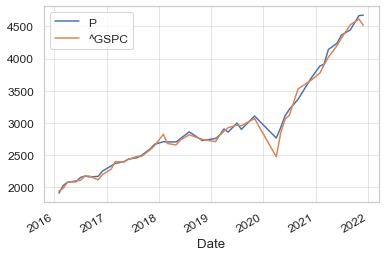

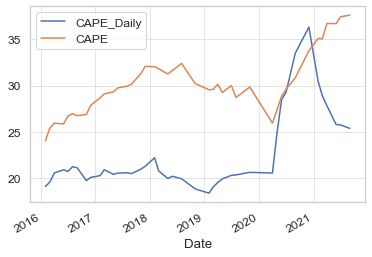

In [6]:
# make a daily CAPE
ticker_df_copy = ticker_df.set_index('Date', inplace=False)
cape_df_D = ticker_df_copy.join(cape_df)
cape_df_D = cape_df_D[date1:date2]

# backfill earnings
col = ['Earnings']
cape_df_D.loc[:,col] = cape_df_D.loc[:,col].bfill()

# make daily CAPE
cape_df_D['CAPE_Daily'] = cape_df_D['^GSPC'] / cape_df_D['Earnings']

# Compare Shiller's data to Yahoo's data
cape_df_D[['P', '^GSPC']].dropna().plot()
plt.show()

# compare CAPE_Daily and CAPE
cape_df_D[['CAPE_Daily', 'CAPE']].dropna().plot()
plt.show()

# close enough ¯\_(ツ)_/¯

In [7]:
ticker_df = cape_df_D[['Open', 'High', 'Low', 'Adj Close', 'Volume', '^VIX', 'CAPE_Daily']]

ticker_df['pct_change'] = ticker_df['Adj Close'].pct_change()

# Are there for look ahead bias? Why 21?
ticker_df['^VIX'] = ticker_df['^VIX'].shift(21)
ticker_df['CAPE_Daily'] = ticker_df['CAPE_Daily'].shift(21) 


#ticker_df['diff'] = ticker_df['Adj Close'].diff()
#ticker_df['5d_pct_change'] = ticker_df['Adj Close'].pct_change(periods=5)
#ticker_df['volume_pct_change'] = ticker_df['Volume'].pct_change()
#ticker_df['std'] = ticker_df['pct_change'].rolling(21).std()

ticker_df.dropna(inplace=True)
# ticker_df.set_index('Date', drop=True, inplace=True)

In [8]:
df_test = ticker_df.loc[:,['Open', 'High', 'Low', 'Adj Close', 'Volume', 'pct_change', '^VIX', 'CAPE_Daily']].copy()
df_test

,Open,High,Low,Adj Close,Volume,pct_change,^VIX,CAPE_Daily
Date,,,,,,,,
2016-02-03,191.410004,191.779999,187.100006,171.403687,205054900,0.005995,20.700001,19.783514
2016-02-04,190.710007,192.750000,189.960007,171.672531,139531800,0.001568,19.340000,19.823323
2016-02-05,190.990005,191.669998,187.199997,168.402145,180788300,-0.019050,20.590000,19.563333
2016-02-08,185.770004,186.119995,182.800003,166.135269,191526700,-0.013461,24.990000,19.099673
2016-02-09,183.360001,186.940002,183.199997,166.144241,184513100,0.000054,27.010000,18.892664
...,...,...,...,...,...,...,...,...
2021-09-27,442.809998,444.049988,441.899994,441.090363,61371100,-0.002861,18.840000,25.054866
2021-09-28,439.690002,440.040009,432.940002,432.201569,130436300,-0.020152,16.389999,25.275540
2021-09-29,435.190002,437.040009,433.850006,432.929016,82329200,0.001683,16.190001,25.384391


# Train the model on a rolling basis (e.g. using obs from the past [x] years)
(yes I know looping through a DataFrame is inefficient - sorry

In [9]:
obs_cols = ['pct_change', 'CAPE_Daily']
components = 2
iterations = 10_000
window = 250*1 #business days
total_rows = len(df_test)
ct = 0

df_test['state'] = np.nan

dats = []
transmats = {}

while ct+window <= total_rows:
    df_sub = df_test.iloc[ct:ct+window,:]
    dat = df_sub.iloc[-1:,:].index
    if len(obs_cols) == 1:
        X = np.column_stack([np.array(df_sub[obs_cols[0]])])
    else:
        X = np.array(df_sub[obs_cols[0]])
        for i in np.arange(1,len(obs_cols)):
            X = np.column_stack([X, df_sub[obs_cols[i]]])
    model = GaussianHMM(components, covariance_type="diag", n_iter=iterations)
    model.fit(X)
    # Optimal sequence of internal hidden state
    hidden_states = model.predict(X)
    df_test.loc[df_test.index == dat[0], 'state'] = hidden_states[-1]    
    # Daily transition matrix
    transmats[dat[0]] = model.transmat_[hidden_states[-1]]    
    ct = ct + 1

# (Rough) calculation of total returns under each state

In [10]:
df = df_test.copy()
# Yesterday's hidden state
df['state_plus_1'] = df.state.shift()

df['df'] = df['pct_change']+1
total_rets = {}
for s in np.arange(0, components):
    total_rets[s] = (df[df['state_plus_1'] == s]['df'].cumprod())
df.dropna(inplace=True)
print(f'Number of state changes: {(df.diff(axis=0) != 0).sum(axis=0)[0]}')

Number of state changes: 1173


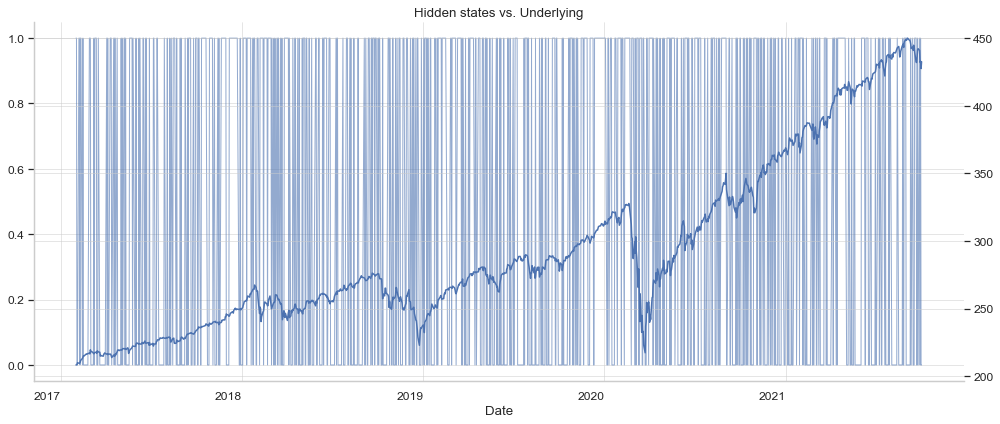

In [11]:
%matplotlib inline
ax1 = df['state_plus_1'].plot(alpha=0.6, title='Hidden states vs. Underlying', figsize=(14,6), lw=1, rot=0)

ax2 = ax1.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
df['Adj Close'].plot(ax=ax2)
plt.tight_layout()
sns.despine();

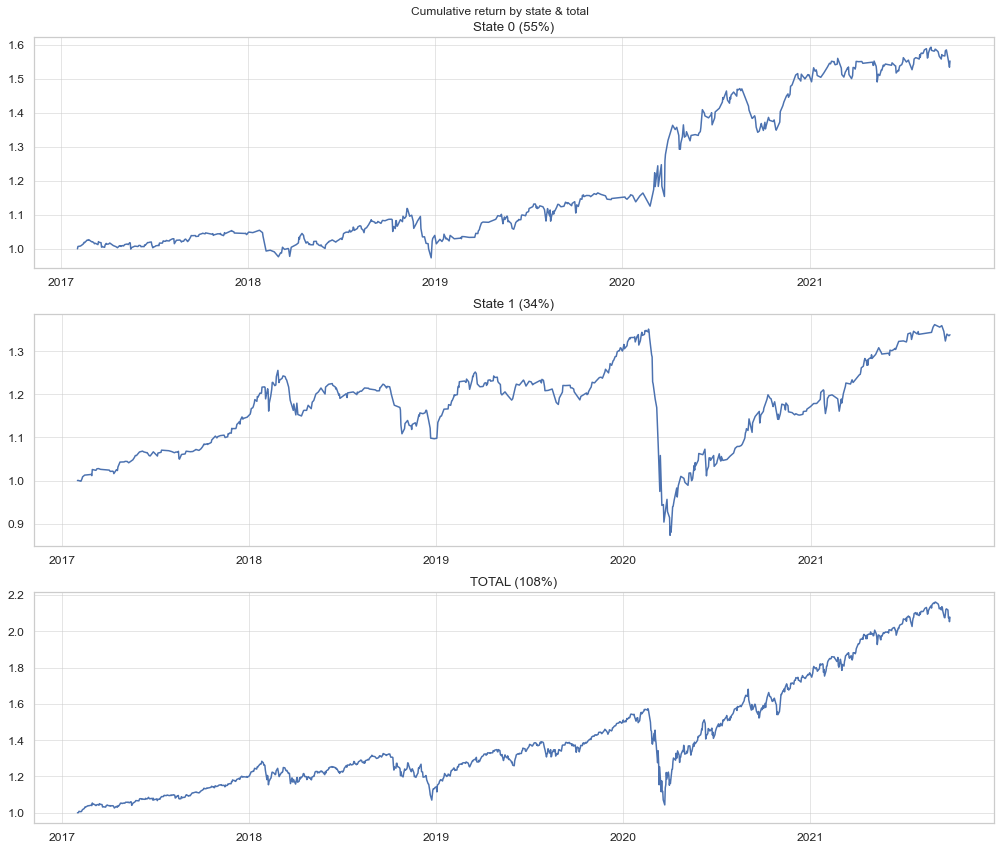

In [12]:
diffB = np.append([0], np.diff(df.state_plus_1))
up = np.where(diffB == 1)[0]
dn = np.where(diffB == -1)[0]
if diffB[np.argmax(diffB!=0)]==-1:
    # we have a falling edge before rising edge, must have started 'up'
    up = np.append([0], up)
if diffB[len(diffB) - np.argmax(diffB[::-1]) - 1]==1:
    # we have a rising edge that never fell, force it 'dn'
    dn = np.append(dn, [len(df.state_plus_1)-1])

fig, axes = plt.subplots(components+1, 1, figsize=(14,12))
for row in range(components):
    ax = axes[row]
    ax.plot(total_rets[row])
    ax.set_title(f'State {row} ({round((total_rets[row][-1]-1)*100)}%)')

ax = axes[components]
ax.plot(df['df'].cumprod())

# for i in range(len(up)):
#     ax.axvspan(df.index[up[i]], df.index[dn[i]], color='r', alpha=0.4, lw=0)
    
tot = df['df'].cumprod()
ax.set_title(f'TOTAL ({round((tot[-1]-1)*100)}%)')

fig.suptitle('Cumulative return by state & total')
fig.tight_layout()
plt.show()

In [13]:
print(np.mean(total_rets[0].pct_change()))
print(np.std(total_rets[0].pct_change())*np.sqrt(252))
print('\n')

print(np.mean(total_rets[1].pct_change()))
print(np.std(total_rets[1].pct_change())*np.sqrt(252))
print('\n')

print(np.mean(tot.pct_change()))
print(np.std(tot.pct_change())*np.sqrt(252))

0.0007848722759971381
0.17545063571670944


0.0006010207394562844
0.20883358011167186


0.000695966124289961
0.1922367605909185
